# Time Series Forecasting with River temperature

### Summary:
- It's important to have a baseline for the predictions and to evalute model performance. The persitance model.
- An effective way to "cross validate" time series is to use a walk-forward validation
- There is a very good package for ARIMA modelling called auto_arima: https://www.alkaline-ml.com/pmdarima/
- Many very effecient models can be used on time series by converting the data to a supervised dataset. Then common scikit algorithms like gradient boosting can be applied, but also neural networks etc. 
- Facebook's forecasting model Prophet is very easy to use and has huge potential: https://facebook.github.io/prophet/. Currently it doesn't handle changes throughout the year, like different variance during summer than winter etc. This can be solved by adding fourier series as regressors or splitting up data data for making different predictions, e.g. by separating weekends from weekdays

### Modelling
This example shows my process in creating a forecast model. The same models and logic can be applied to any time series data. I use the mean daily temparture dataset from datamarket in this example https://datamarket.com/data/set/235d/mean-daily-temperature-fisher-river-near-dallas-jan-01-1988-to-dec-31-1991#!ds=235d&display=line

Before these models were developed, they were visualized as described: https://github.com/steeks91/Data-Science-Portfolio/blob/master/Visualizations/Visualizations-Time-Series.ipynb 

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/steeks91/Data-Science-Portfolio/master/Data/mean-daily-temperature-fisher-ri.csv"
df = pd.read_csv(url, sep=";", names=["Date", "Mean daily temperature"], skiprows=1)

#Convert mean daily temperature to numeric
df["Mean daily temperature"] = df["Mean daily temperature"].str[1:]
df["Mean daily temperature"] = pd.to_numeric(df["Mean daily temperature"])

#Convert to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index('Date')

#Replace nan with mean
df = df.fillna(df.mean())

#Convert to series
df = df["Mean daily temperature"]

df.head()

Date
1988-01-01    23.0
1988-01-02    20.5
1988-01-03    22.0
1988-01-04    30.5
1988-01-05    31.0
Name: Mean daily temperature, dtype: float64

In [19]:
#Split into a dataset for development and keeping last three months for validation
from dateutil.relativedelta import relativedelta

last_date = max(df.index)
end_dataset = last_date + relativedelta(months = -3)
start_validation = end_dataset + relativedelta(days=1)
dataset, validation = df[:end_dataset], df[start_validation:]
print("Dataset %d months, Validation %d months" % (len(dataset), len(validation)))

#split the dataset into a train set and a test set
split_point = int(len(dataset) * 0.5)
train, test = dataset[:split_point], dataset[split_point:]
print("Train size %d months, Test size %d months" % (len(train), len(test)))

Dataset 1369 months, Validation 92 months
Train size 684 months, Test size 685 months


### Persistance model
Implement a persistance model as baseline. In my case I had manual predictions done by analysts to compare with. If nothing else is available, the persistance model is a good baseline. 
I chose to use the RMSE as the error metric since that is punishing larger errors and optimizing to get the mean as low as possible

If plotted, it can be seen that the peristance model's predictions are always lagged with one day

RMSE: 4.492


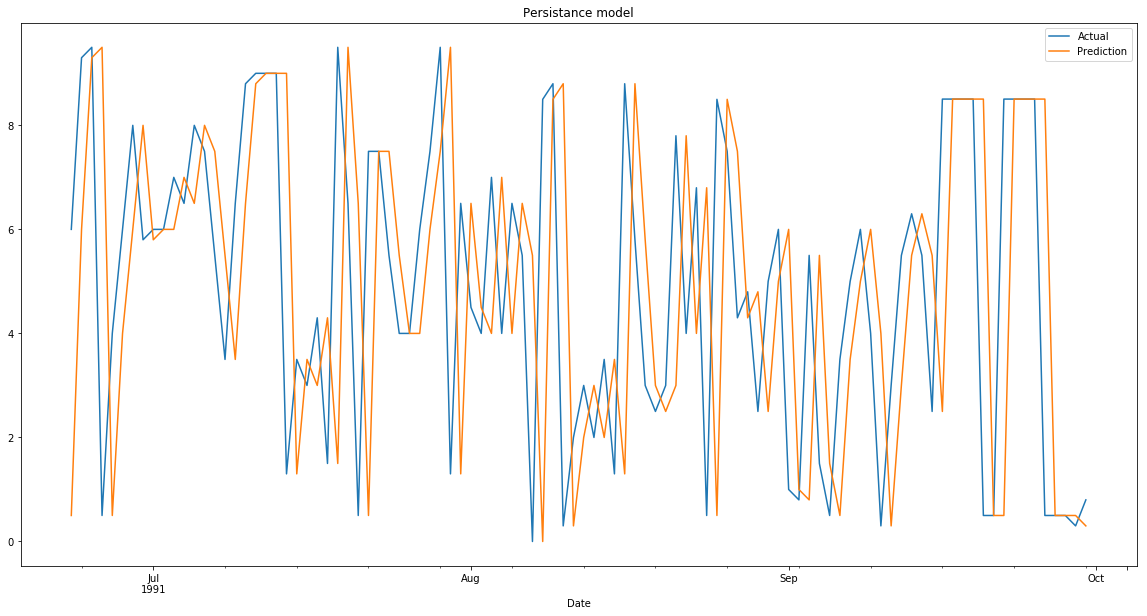

In [24]:
#Persistance modelling
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

predictions = pd.Series(predictions, index=test.index, name="Prediction")
pd.concat([test, predictions], axis=1, keys=["Actual", "Prediction"])[-100:].plot(figsize=(20,10), title="Persistance model")

### Autoregressive model (static)

The autoregressive model assumes correlation between a value and the lagged values. I.e. it uses a linear combination of previous observations to predict future values.

The score is barely better than the persistance model

C:\Users\stefan.ekstrom\AppData\Local\Continuum\Anaconda3\envs\sasrev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Test RMSE: 4.357


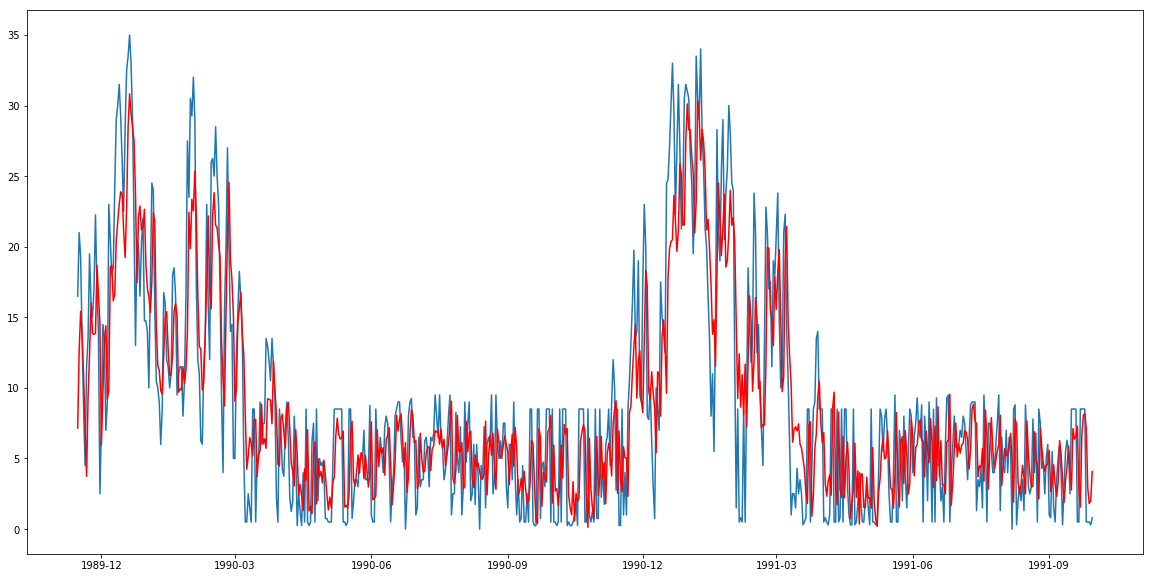

In [26]:
#Autoregression model that always makes predictions on the last n-dates (dynamic)

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

# plot
fig = plt.figure(figsize=(20,10))
predictions = pd.DataFrame(predictions, index=test.index)[0] #make predictions have the same index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### Auto ARIMA model
First of all, this package is not done justice in this notebook due to the data. 
The package is a wrapp-around to the popular R-package auto_arima. This makes it easy to use and train a good arima model. 

Also, the model can easily be improved by adding other features by setting exogenous=X when initializing the auto_arima model, and when training/adding observations to the model. This could be number of days in month, holidays....

The reason for the bad predictions is most likely due to the fact that the model fails to include the MA-paramater for the temperature dataset. 

In [40]:
####Create an auto arima model######
from pyramid.arima import auto_arima

#Had to enforce the q-paramter to be 0, otherwise the model broke for this data. Change to other if possible
stepwise_model = auto_arima(dataset, start_p=1, start_q=0,
                            max_p=3, max_q=0, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action="ignore",
                            suppress_warnings=True,
                            stepwise=True
                           )

print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=7963.539, BIC=7984.388, Fit time=4.819 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=8935.297, BIC=8945.721, Fit time=0.136 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=8491.103, BIC=8511.952, Fit time=1.989 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=8007.837, BIC=8023.474, Fit time=5.633 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=7963.808, BIC=7989.869, Fit time=7.724 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=8895.338, BIC=8910.975, Fit time=0.439 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=7963.757, BIC=7989.819, Fit time=21.795 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=7967.266, BIC=7998.539, Fit time=15.586 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=7924.144, BIC=7950.205, Fit time=7.105 seconds
Fit ARIMA: order=(2, 1, 0)

Test RMSE: 9.279


<Figure size 1440x720 with 0 Axes>

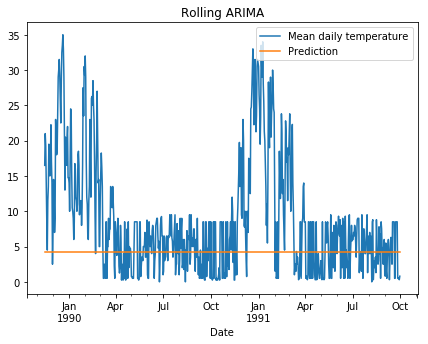

In [41]:
#####Make walk-forward validations#######

#Initialize the model
history = [x for x in train]
predictions = list()

#initialize the model
stepwise_model.fit(history[:-1])

#Retrain the model after every step
for t in range(len(test)):
    stepwise_model.add_new_observations(history[-1:])
    output = stepwise_model.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

predictions = pd.DataFrame(predictions, index=test.index, columns=["Prediction"])
fig = plt.figure(figsize=(20,10))
pd.concat([test, predictions], axis=1).plot(figsize=(7,5), title="Rolling ARIMA")

### Supervised model
By converting the dataset to a supervised dataset, all supervised models can be used to make the predictions. If adding lagged features to the model a replication of the autoregression model (and ARIMA model) can be created.

To make it more useful, I'm doing predictions for the next month in this example.

In [65]:
# Prepare the dataset###
import datetime
from dateutil import relativedelta as rd

def get_closest_weekday_last_year(date):
    """Takes as a datetime and returns the closest weekday last year"""
    date_ly = date - rd.relativedelta(years=1)
    weekday = date.weekday()
    closest_weekday_ly = next_weekday(date_ly, weekday)  
    return closest_weekday_ly

def get_closest_weekday_last_month(date):
    """Takes a date and returns the last closest weekday last month"""
    weekday = date.weekday()
    first_day_month = datetime.date(date.year, date.month, 1)
    date_lm = first_day_month - rd.relativedelta(weeks=1) 
    closest_weekday_lm = next_weekday(date_lm, weekday)
    return closest_weekday_lm 
    
def next_weekday(d, weekday):
    """Takes a datetime object and a weekday and return the next occurance of the weekday"""
    days_ahead = (weekday - d.weekday()) % 7
    return d + datetime.timedelta(days_ahead)

def get_outcome_for_closest_date_last_period(dataset, last_period="year"):
    """Takes in as Series of values and returns the outcome variable for the closest date last period"""
    outcomes_last_period = []
    for date in dataset.index:
        
        #Get last date for the chosen period
        if last_period == "year":
            closest_weekday = get_closest_weekday_last_year(date)
        elif last_period == "month":
            closest_weekday = get_closest_weekday_last_month(date)
        elif last_period == "day":
            closest_weekday = date - rd.relativedelta(days=1) 
        else:
            raise ValueError("Wrong period specified, only 'year', 'month' or 'day' are valid")
            
        #Try to get the outcome for the date last year. If the date is not present in the dataset, then add None.
        try:
            sale_lp = dataset[closest_weekday]
        except KeyError:
            sale_lp = None
        
        #Add the outcome for the last period
        outcomes_last_period.append(sale_lp)
    
    outcomes_last_period = pd.Series(outcomes_last_period, name="outcome_last_%s" % last_period, index=dataset.index)
    return outcomes_last_period

def day_of_week(dataset):
    """Takes a dataset with datetime index and returns the weekdays as dummies"""
    
    day_of_week=[]
    for day in dataset.index:
        day_of_week.append(day.strftime("%A"))
    
    #Converts to pandas dataframe and get dummies variables. With drop_first=true so only 6 features --> all 0 --> 7th date
    day_of_week = pd.Series(day_of_week, name="weekday", index=dataset.index)
    day_of_week = pd.get_dummies(day_of_week, drop_first=True)
    return day_of_week

def month_name(dataset):
    """Takes a dataset with datetime index and returns the months as dummies"""
    
    month_name=[]
    for day in dataset.index:
        month_name.append(day.strftime("%B"))
        
    #Converts to pandas dataframe and get dummies variables. With drop_first=true so last month is where all rest=0
    month_name = pd.Series(month_name, name="month_name", index=dataset.index)
    month_name = pd.get_dummies(month_name, drop_first=True)
    return month_name

def season_name(dataset):
    """Takes a dataset with datetime index and returns the seasons as dummies"""
    
    season_name=[]
    for day in dataset.index:
        if 3 <= day.month < 6:
            season_name.append("Spring")
        elif 6 <= day.month < 9:
            season_name.append("Summer")
        elif 9 <= day.month < 12:
            season_name.append("Autumn")
        else:
            season_name.append("Winter")
            
    #Converts to pandas dataframe and get dummies variables. With drop_first=true so last season is where all rest=0
    season_name = pd.Series(season_name, name="season_name", index=dataset.index)
    season_name = pd.get_dummies(season_name, drop_first=True)
    return season_name

def day_of_month(dataset):
    """Takes a dataset with datetime index and returns the day of months as dummies"""
    
    day_of_month=[]
    for day in dataset.index:
        day_of_month.append(day.day)
    
    #Converts to pandas dataframe and get dummies variables 
    day_of_month = pd.Series(day_of_month, name="day_of_month", index=dataset.index)
    day_of_month = pd.get_dummies(day_of_month, prefix="monthday")
    return day_of_month

def prepare_categorical_features(dataset):
    """Takes a pandas dataframe and returns a transformed dataframe with all categorical features as dummies"""
    #category_columns = dataset.select_dtypes(["category"])
    
    dataset = pd.get_dummies(dataset)
    return dataset

#Copy the df
super_df = df

#Get the features for the same date last year
temp_ly = get_outcome_for_closest_date_last_period(super_df, last_period="year")
temp_lm = get_outcome_for_closest_date_last_period(super_df, last_period="month")
temp_ld = get_outcome_for_closest_date_last_period(super_df, last_period="day")

#Months, seasons, week patterns
weekday = day_of_week(super_df)
month = month_name(super_df)
season = season_name(super_df)
monthday = day_of_month(super_df)

#Combine the data
super_df = pd.concat([super_df, 
                      temp_ly, 
                      temp_lm, 
                      temp_ld,
                     weekday,
                     month,
                     season,
                     monthday], axis=1)

#Prepare categorical features
super_df = prepare_categorical_features(super_df)

#Drop NaN
super_df = super_df.dropna()
print("Length of total data: %d days" % len(super_df))

#Split into a dataset for development and testing
last_date = max(super_df.index)
end_dataset = last_date + relativedelta(months = -3)
start_validation = end_dataset + relativedelta(days=1)
dataset, validation = super_df[:end_dataset], super_df[start_validation:]
print("Dataset %d months, Validation %d months" % (len(dataset), len(validation)))

#split the dataset into a train set and a test set
split_point = int(len(dataset) * 0.5)
train, test = dataset[:split_point], dataset[split_point:]
print("Train size %d months, Test size %d months" % (len(train), len(test)))

#Split into predictors and targets
X_train, y_train = train.iloc[:, 1:], train.iloc[:, :1]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, :1]

Length of total data: 1097 days
Dataset 1005 months, Validation 92 months
Train size 502 months, Test size 503 months


In [67]:
def walk_forward_predictions(X_train, y_train, X_test, y_test, model):    
    history_X = X_train
    history_y = y_train
    calendar_left = X_test.index
    future_X = X_test #This should not be needed when fully implemented
    future_y = y_test #This should not be needed when fully implemented
    predictions = list()
    
    while len(calendar_left)>0:
        #retrain the model
        model.fit(history_X, history_y.values.ravel())

        #make predictions for the next day
        n_days = 1
        days_to_predict = future_X[:n_days]
        yhat = model.predict(days_to_predict)

        #Save the predictions
        predictions.extend(yhat)

        #Update the data to rerun the model
        history_X = pd.concat([history_X, future_X[:n_days]])
        history_y = pd.concat([history_y, future_y[:n_days]])
        future_X = future_X[n_days:]
        future_y = future_y[n_days:]
        calendar_left = calendar_left[n_days:]
    
    predictions = pd.DataFrame(predictions, index=y_test.index, columns=["Prediction"]) 
    
    score = model.score(X_test, y_test)
    print("Score: ", round(score*100, 3))
    
    return predictions, model

#### Gradient boosted tree model

Score:  86.66
Test RMSE: 4.049


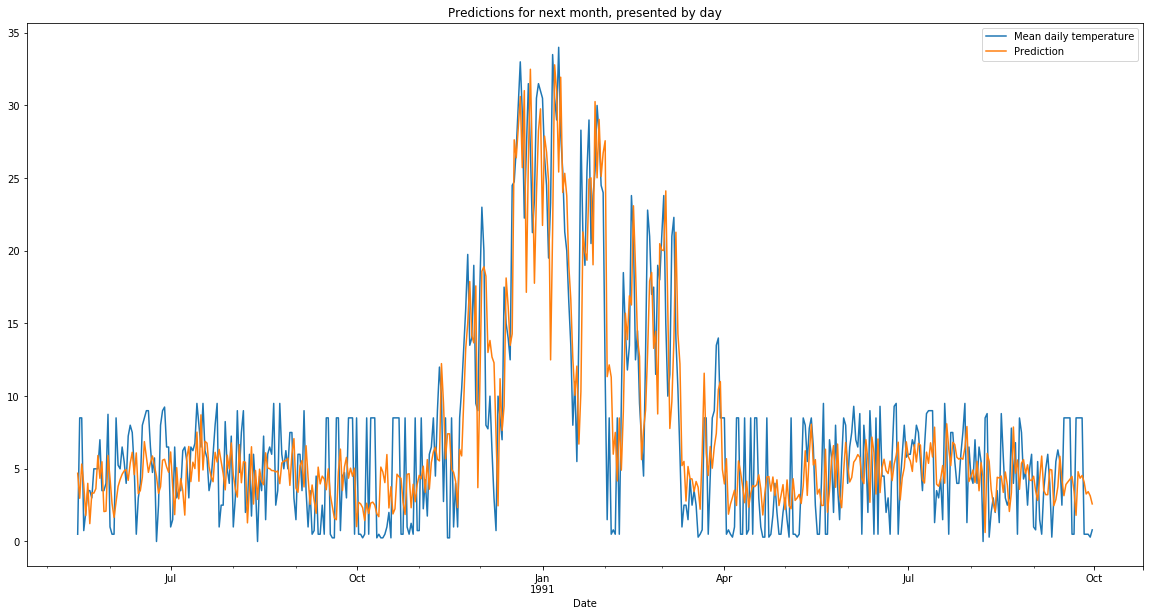

In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

model = GradientBoostingRegressor(n_estimators=200, random_state=160)
predictions, model = walk_forward_predictions(X_train, y_train, X_test, y_test, model)

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

pd.concat([y_test, predictions], axis=1).plot(figsize=(20,10), title="Predictions for next month, presented by day")

outcome_last_year, importance: 0.02977923046486814
outcome_last_month, importance: 0.029965204433142344
outcome_last_day, importance: 0.8523871170984553
Monday, importance: 0.0015817874934613745
Saturday, importance: 0.001306432290043464
Sunday, importance: 0.00085529844477569
Thursday, importance: 0.0009639687641997412
Tuesday, importance: 0.003440620981284471
Wednesday, importance: 0.0029142264485077425
August, importance: 0.00033682147952136934
December, importance: 0.003443374433995846
February, importance: 0.0033929298032759126
January, importance: 0.002362728127852753
July, importance: 0.001225992533407658
June, importance: 0.0010900203328915857
March, importance: 0.00013670962948066892
May, importance: 0.0014076653661628461
November, importance: 0.0022761915507897297
October, importance: 0.0013693674464859908
September, importance: 0.00019785970887801815
Spring, importance: 0.0003805142880842517
Summer, importance: 0.0007095609286229309
Winter, importance: 0.023671271591166873
m

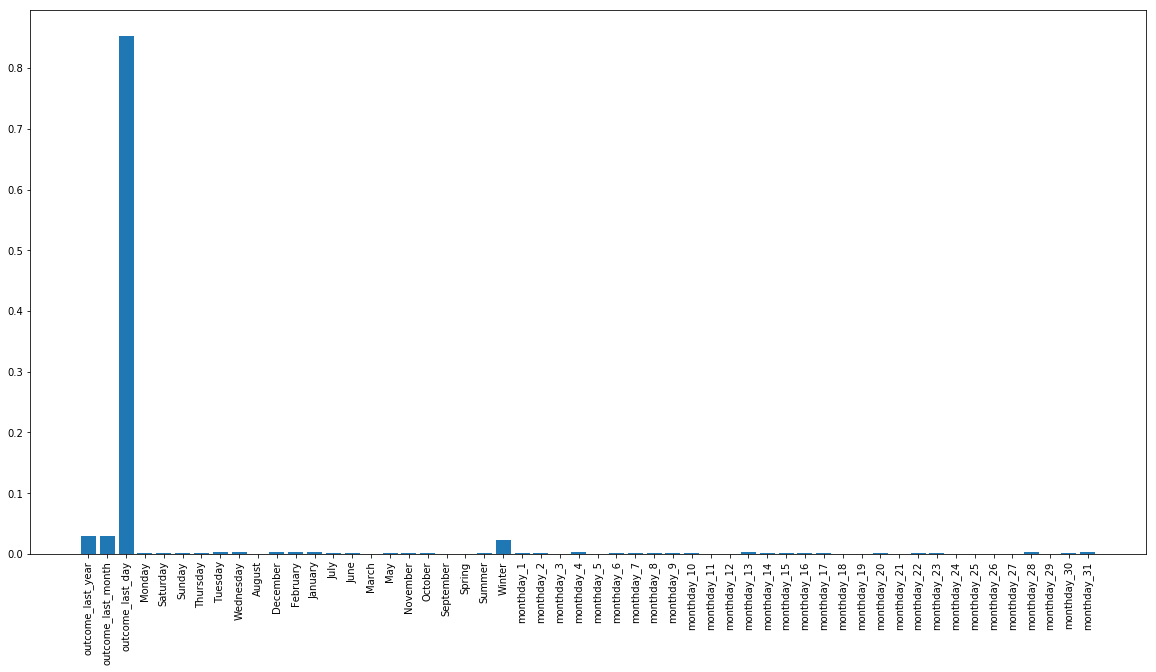

In [69]:
###Plot feature importance
for i in range(len(X_test.columns.values)):  
    print("%s, importance: %s" % (X_test.columns.values[i], model.feature_importances_[i]))

# plot importance scores
names = X_test.columns.values
ticks = [i for i in range(len(names))]
fig = plt.figure(figsize=(20,10))
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names, rotation='vertical')

plt.show()

#### Linear regression

Score:  71.894
Test RMSE: 4.111


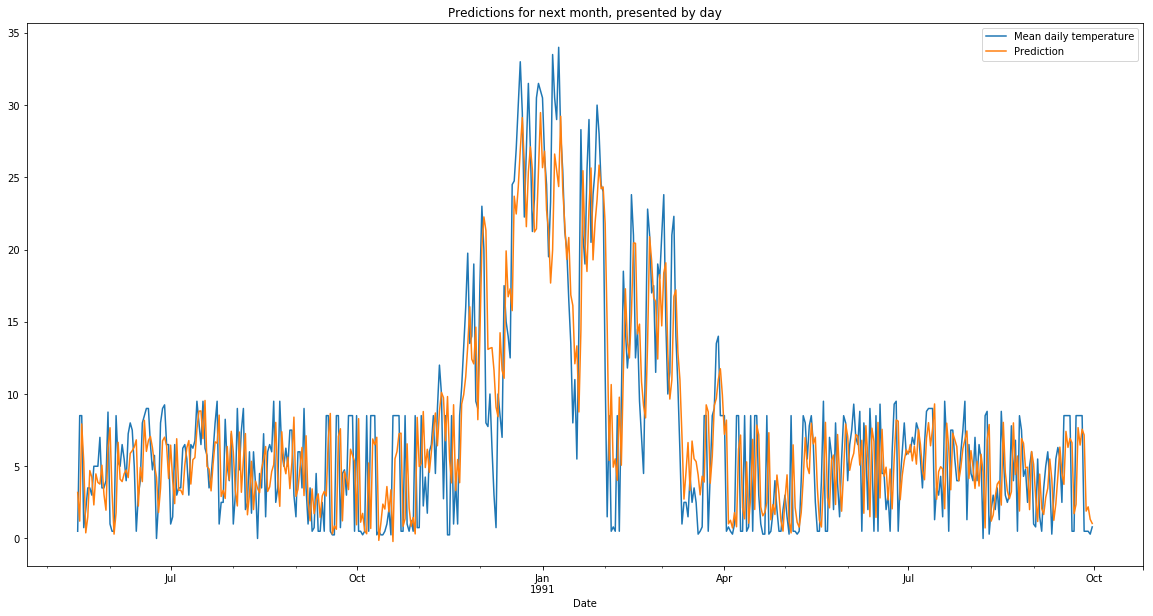

In [70]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
predictions, model = walk_forward_predictions(X_train, y_train, X_test, y_test, model)

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

pd.concat([y_test, predictions], axis=1).plot(figsize=(20,10), title="Predictions for next month, presented by day")

Text(0.5,1,'Predictions to true values Linear Regression')

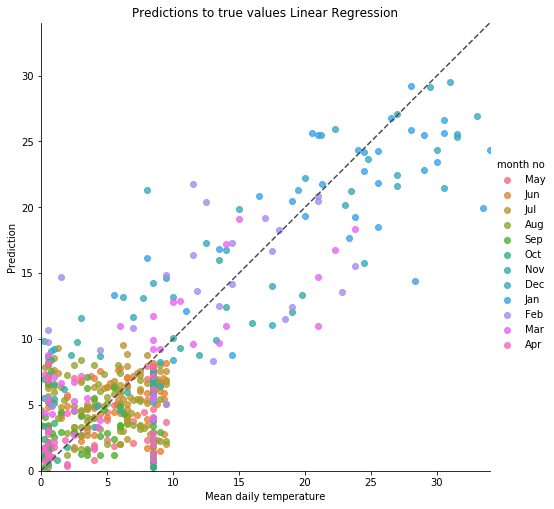

In [71]:
###Plot predictions compared to true values###
data = pd.concat([y_test, predictions], axis=1)

import seaborn as sns
data_month = data
data_month["month no"] = data.index.strftime("%b")
sns.lmplot(x="Mean daily temperature",
          y="Prediction",
           data=data_month,
          hue="month no",
          fit_reg=False,
          height=7,
          aspect=1)

#plot equal axises
max_axis = max(predictions.max().values[0], y_test.max().values[0])
plt.ylim(0, max_axis)
plt.xlim(0, max_axis)

ax = plt.gca()
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_title("Predictions to true values Linear Regression")

### Feature Reduction

In [72]:
#Using Recursive feature elimination with Gradient boosted tree
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

clf = GradientBoostingRegressor(n_estimators=200, random_state=160).fit(X, y.values.ravel())
trans_model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features=30)
X = trans_model.transform(X)

features_idx=trans_model.get_support()
features_remain=X_train.columns[features_idx]


X_train_trimmed = pd.DataFrame(X[:len(X_train)], index=X_train.index, columns=features_remain)
X_test_trimmed = pd.DataFrame(X[len(X_train):], index=X_test.index, columns=features_remain)

print("Removed %d columns" % len(features_idx[features_idx==False]))

print("Kept columns:")
for column in features_remain.values:
    print(column)
    

Removed 24 columns
Kept columns:
outcome_last_year
outcome_last_month
outcome_last_day
Monday
Saturday
Sunday
Tuesday
Wednesday
December
February
January
July
May
November
Winter
monthday_2
monthday_4
monthday_7
monthday_8
monthday_9
monthday_10
monthday_13
monthday_14
monthday_15
monthday_16
monthday_20
monthday_23
monthday_28
monthday_30
monthday_31


Score:  71.011
Test RMSE: 4.092


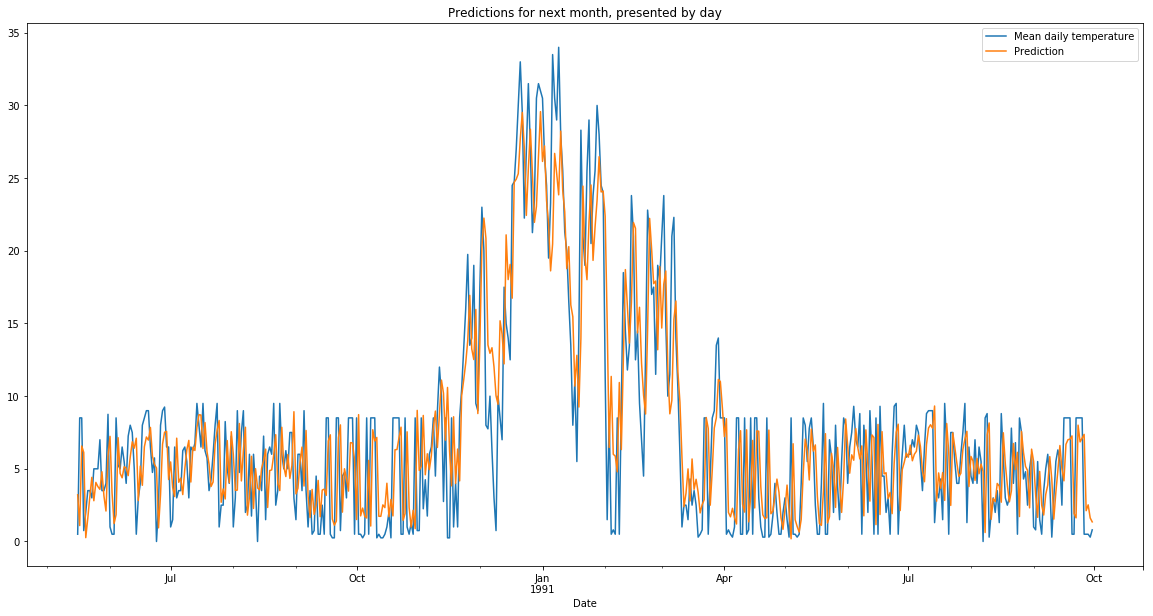

In [73]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
predictions = month_walk_forward_predictions(X_train_trimmed, y_train, X_test_trimmed, y_test, model)

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

pd.concat([y_test, predictions], axis=1).plot(figsize=(20,10), title="Predictions for next month, presented by day")

## Using Facebook's prophet model
Here a prediction for the next month is done. This is beacause the model is rather computationally expensive, and to do this on a daily level is neither necessary nor wanted. 

The model is showing a much smoother prediction than the previous models (except ARIMA). The model is performing very good when the data is aggregated on a higher level. For example average temperature on a monthly level. Potentially it can also be used as an input to anot  

In [75]:
###Prepare for handling by Prophet, which requires the names to be 'y' and 'ds'

#Convert to Dataframe
prophet_df = pd.DataFrame(df)
prophet_df["ds"] = prophet_df.index
prophet_df["y"] = prophet_df["Mean daily temperature"]
prophet_df = prophet_df.drop(["Mean daily temperature"], axis=1)

In [80]:
#Split into a dataset for development and testing
last_date = max(prophet_df.index)
end_dataset = last_date + relativedelta(months = -3)
start_validation = end_dataset + relativedelta(days=1)
dataset, validation = prophet_df[:end_dataset], prophet_df[start_validation:]
print("Dataset %d months, Validation %d months" % (len(dataset), len(validation)))

#split the dataset into a train set and a test set
split_point = int(len(dataset) * 0.5)
train, test = dataset[:split_point], dataset[split_point:]
print("Train size %d months, Test size %d months" % (len(train), len(test)))

Dataset 1369 months, Validation 92 months
Train size 684 months, Test size 685 months


In [81]:
###Monthly walk-forward prediction
def length_of_next_month(dates):
    month = dates[0].month
    year = dates[0].year
    dates_in_month =(dates[(dates.month==month) & (dates.year==year)])
    return len(dates_in_month)

def month_walk_forward_predictions_prophet(train, test, holidays_data=None, seasonality_prior_scale=10, holiday_prior_scale=10, holidays=None):
    from fbprophet import Prophet
    
    history = train
    calendar_left = test.index
    future = test #This should not be needed when fully implemented
    predictions = list()
    
    while len(calendar_left)>0:
        #create a new object since Prophet is currently not supporing warm start
        model = Prophet(holidays=holidays_data, seasonality_prior_scale=seasonality_prior_scale)
        model.fit(history)

        #make predictions for the next month
        days_in_month = length_of_next_month(calendar_left)
        future_input = model.make_future_dataframe(periods=days_in_month) #Replaced when adding holidays
        forecast = model.predict(future_input)
        yhat = forecast["yhat"].iloc[-days_in_month:] #only keep the predictions

        #Save the predictions
        predictions.extend(yhat)

        #Update the data to rerun the model
        history = pd.concat([history, future[:days_in_month]])
        future = future[days_in_month:]
        calendar_left = calendar_left[days_in_month:]
    
    predictions = pd.DataFrame(predictions, index=test.index, columns=["Prediction"])
    
    return predictions, model, forecast

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=Tr

Test RMSE: 7.192


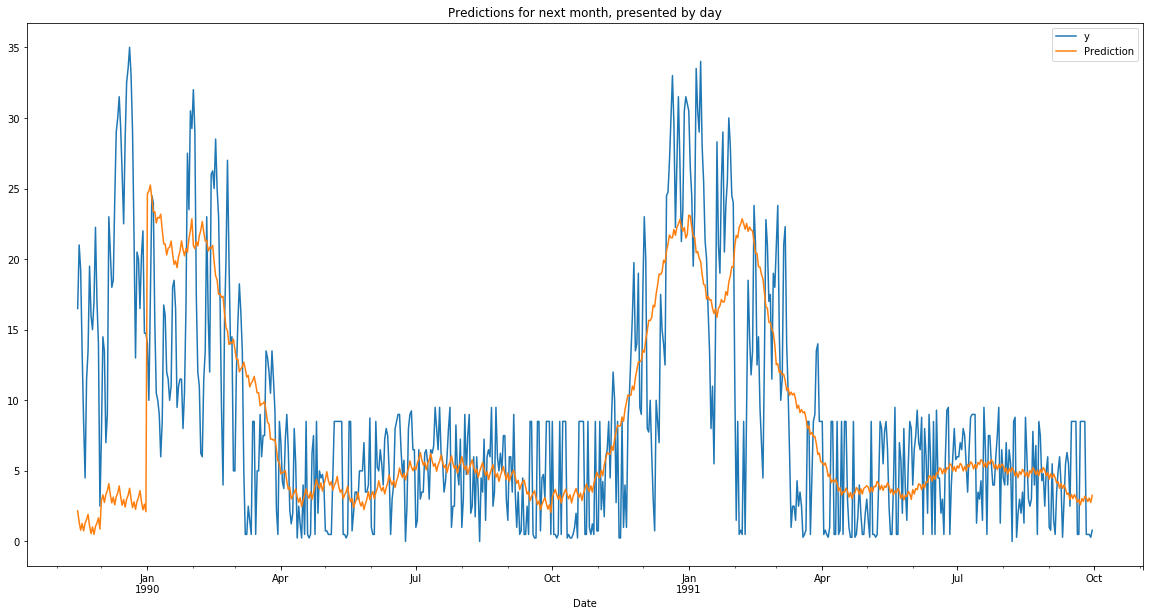

In [83]:
###Do a monthly walk-forward prediction

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Make walk-forward predictions
predictions, _, _= month_walk_forward_predictions_prophet(train, test)

#Calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test["y"], predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

pd.concat([test["y"], predictions], axis=1).plot(figsize=(20,10), title="Predictions for next month, presented by day")